## Loading IPA model

In [1]:
#!/usr/bin/env python
# coding: utf-8
import warnings
warnings.filterwarnings("ignore", "WARNING")

from scipy.io import loadmat
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", palette='muted')

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tqdm.keras import TqdmCallback

from python.architecture_tf import get_ipa_model
from python.plot_utils import *
from python.regression_utils import cnn_prediction

SEED_VALUE = 1
seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
tf.keras.utils.set_random_seed(SEED_VALUE)

print(f'TF v {tf.__version__} & Keras v {tf.keras.__version__}')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Memory growth activated')

TF v 2.10.1 & Keras v 2.10.0
Memory growth activated


In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from tqdm import tqdm

In [3]:
data = loadmat("data/raw-kennard-reduced_range.mat")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
W = data['Wcal'][0]

scalerX = StandardScaler()
scalerY = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

""" REGULARIZATION HPs """
LEARNING_RATE = .001
REGULARIZATION_COEF = .0095
DROPOUT_RATE = .2

""" Base training HPs """
BATCH_SIZE = 16
EPOCHS = 500
MODEL_NAME = 'IPA-Keras'
path_model = 'model/'

Model does exist, performing regression.
3/3 [==============================] - 2s 21ms/step
RMSEP: 0.099 - R2: 0.991 - Ratio: 1.129
RMSEC: 0.112
Scaled RMSEP 1.074


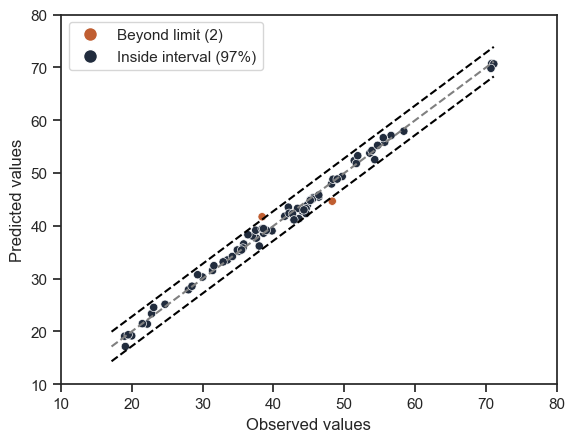

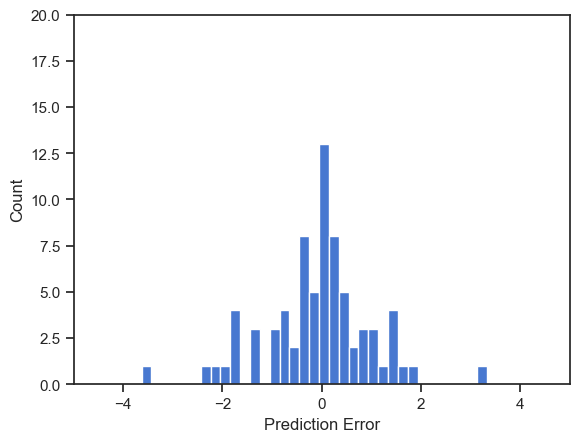

In [4]:
if not os.path.exists(path_model + MODEL_NAME):
    print('Model does not exists, training in progress...')

    # Model input
    n_wavelength = X_train_reshaped.shape[1]
    fill_dimension = 1
    input_spectra = Input(shape=(n_wavelength, fill_dimension))

    model = get_ipa_model(input_spectra,
                          seed_value=SEED_VALUE,
                          regularization_factor=REGULARIZATION_COEF,
                          dropout_rate=DROPOUT_RATE,
                          model_name=MODEL_NAME)

    # Optimization parameters
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=10000, decay_rate=.001)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mse'])
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

    # Performing model training
    history = model.fit(
        X_train_reshaped, y_train_scaled,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_reshaped, y_test_scaled),
        callbacks=[stop_early, TqdmCallback(verbose=0)],
        verbose=0,  # Suppress logging.
    )

    # Regression
    RMSEP, R2P, y_preds = cnn_prediction(model, scalerY,
                                         X_train_reshaped, X_test_reshaped,
                                         y_train_scaled, y_test_scaled)
    plot_history(history, RMSEP, R2P)
    plot_val(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds))

    print('Saving model')
    model.save(path_model + MODEL_NAME, overwrite=True, save_format='h5')


else:
    print('Model does exist, performing regression.')
    model = tf.keras.models.load_model(path_model + MODEL_NAME)

    # Regression
    _, _, y_preds = cnn_prediction(model, scalerY, X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled)
    plot_val(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds), 
             rmse_limit=2.8, axes=[10, 80])
    plot_err(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds), 
             deviation=5, n_count=20)


## Grad-CAM medium CN - [43, 44.5]

In [5]:
df_y = pd.DataFrame(y_train, columns=['value'])

In [6]:
def plot_df(dataframe, xlabel, fontsize=30):
    dataframe.columns = xlabel
    _, ax = plt.subplots(1, figsize=(18,8))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-7)

    ax.plot(dataframe.transpose())
    ax.set(xlim=(3800, 12500))
    ax.set(ylim=(-.5, 1))
    plt.xlabel("Wavenumbers cm-1", fontsize=fontsize)
    plt.ylabel("Absorbance", fontsize=fontsize)
    plt.show()

17 samples : [1, 9, 38, 48, 60, 73, 75, 78, 91, 97, 103, 109, 113, 124, 138, 139, 158]


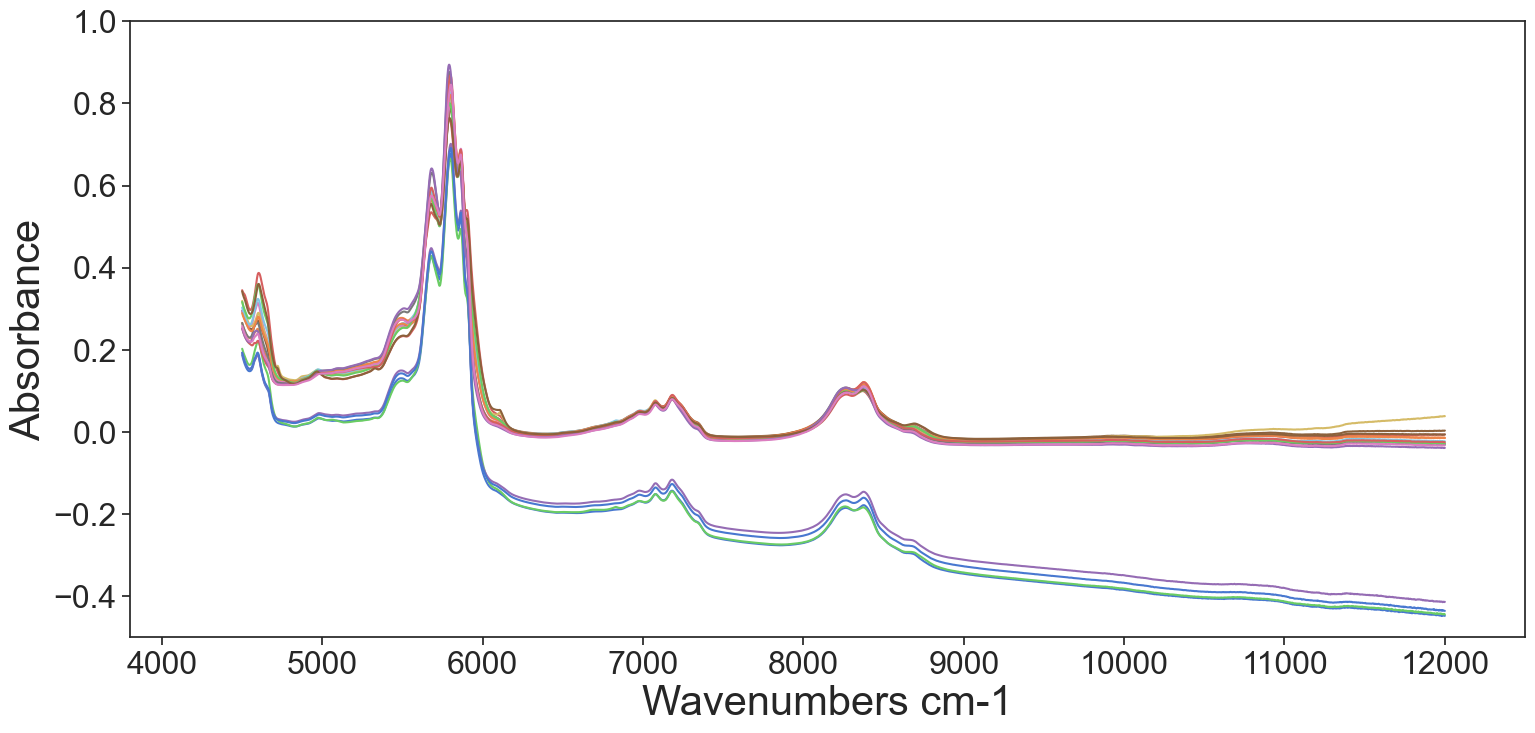

In [7]:
index_list = list(df_y[df_y['value'].between(43.,44.5)].index)
print(len(index_list), 'samples :', index_list)
plot_df(pd.DataFrame(X_train[index_list]), W)

14 samples : [2, 6, 8, 16, 17, 23, 29, 53, 58, 59, 94, 101, 126, 148]


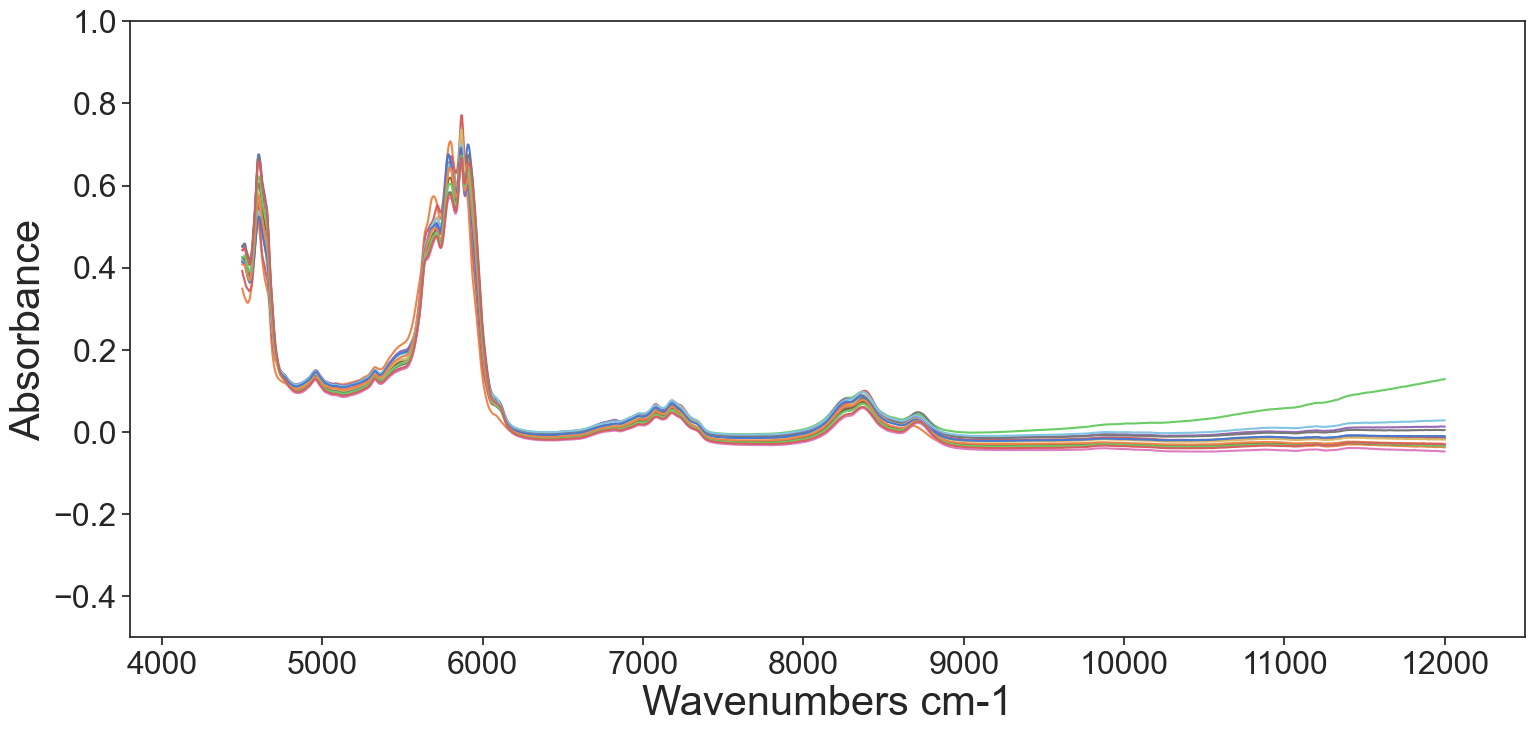

In [8]:
index_list = list(df_y[df_y['value'].between(19.,28.)].index)
print(len(index_list), 'samples :', index_list)
plot_df(pd.DataFrame(X_train[index_list]), W)

6 samples : [14, 32, 52, 96, 125, 143]


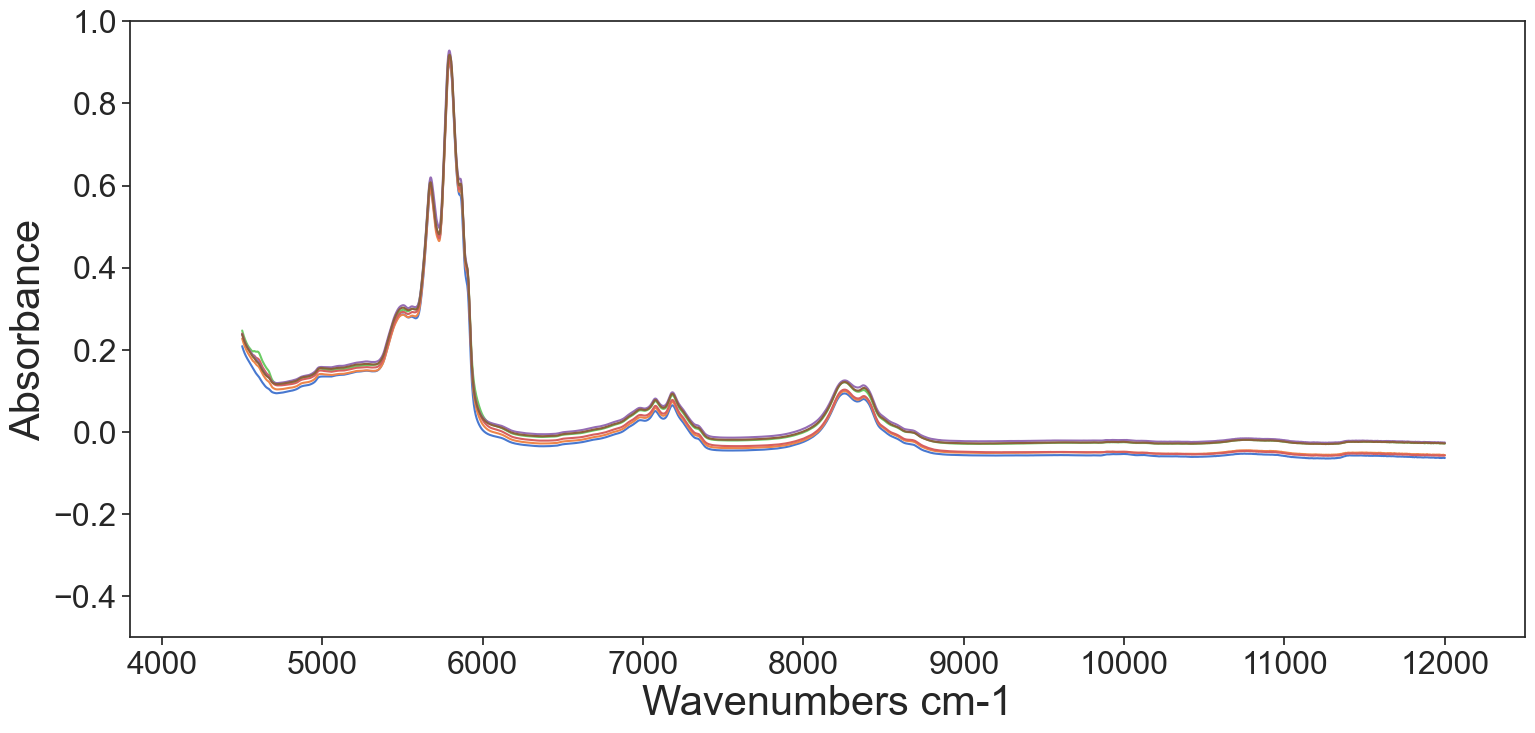

In [9]:
index_list = list(df_y[df_y['value'].between(63.,72.)].index)
print(len(index_list), 'samples :', index_list)
plot_df(pd.DataFrame(X_train[index_list]), W)

## Correlation between baseline and activation these samples

In [10]:
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]] # Filtering layers that matters
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [11]:
model_output = activation_model.predict(X_train_reshaped)
len(model_output)

6/6 [==============================] - 0s 5ms/step


17

In [12]:
i_layer = 0
i_spectr = 0

layer_names = []
for layer in model.layers[:len(model.layers)]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    i_layer=i_layer+1
    layer_activation=model_output[i_layer-1]
    if layer.name in ['conv1d_2', 'conv1d_5', 'conv1d_6', 'conv1d_9', 'conv1d_8']:
        print(str(i_layer)+' '+layer.name+' '+str(layer_activation.shape))
i_layer=0

4 conv1d_2 (174, 1940, 32)
9 conv1d_9 (174, 241, 64)
10 conv1d_5 (174, 485, 64)
11 conv1d_6 (174, 968, 64)
13 conv1d_8 (174, 970, 64)


In [13]:
import numpy as np
from scipy import interpolate

def interpolate_array(arr: np.ndarray, new_shape: tuple):
    """
    Interpolates a numpy array using scipy's interp1d function.

    Parameters:
    arr (ndarray): The input numpy array with shape (1, N).
    new_shape (tuple): The desired new shape of the array in the form (1, M).

    Returns:
    ndarray: The interpolated numpy array with shape new_shape.
    """
    old_shape = arr.shape
    assert len(old_shape) == 2 and old_shape[0] == 1, "Input array should have shape (1, N)"
    assert len(new_shape) == 2 and new_shape[0] == 1, "New shape should be (1, M)"

    old_size = old_shape[1]
    new_size = new_shape[1]

    x = np.linspace(0, 1, old_size)
    x_new = np.linspace(0, 1, new_size)
    f = interpolate.interp1d(x, arr[0], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_arr = f(x_new)
    return interpolated_arr.reshape(new_shape)


In [14]:
def utils_np_to_df(array, wavenumbers, index_name):
    df = pd.DataFrame(array)
    df.columns = wavenumbers
    df.index = [index_name]
    return df

In [15]:
key_to_idx = {
    'stem1': {'idx': 1},
    'stem2': {'idx': 2},
    'stem3': {'idx': 4},
    'branch1': {'idx': 10},
    'branch2': {'idx': 11},
    'branch3': {'idx': 9},
    'branch4': {'idx': 13}
}

stem = list(key_to_idx.keys())[:3]
branches = list(key_to_idx.keys())[3:]

selected_activations = model_output

In [16]:
def plot_heatmap(activations):
    # Base fig + pandas
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    df = pd.DataFrame(activations)
    df.index = y_train[:,-1]
    df = df.sort_index(ascending=False)
    df.columns = W.astype(int)

    sns.heatmap(df, cmap='turbo')
    
    # Color bar
    cbar_ticks = np.linspace(np.min(df), np.max(df), 5)
    ax.collections[0].colorbar.set_ticks(cbar_ticks)
    ax.collections[0].colorbar.set_ticklabels(['Very low', 'Low', 'Medium', 'High', 'Very high'])
    # ax.tick_params(axis='x', rotation=65)

In [17]:
def calculate_gradcam():   
    interpolated_spectra = np.zeros(X_train.shape)
    for spectrum_idx in tqdm(range(X_train.shape[0])):
        interpolated_spectrum = interpolate_array(
            gap[np.newaxis,spectrum_idx], 
            new_shape=X_train[np.newaxis,0].shape)
        interpolated_spectra[spectrum_idx] = interpolated_spectrum
    return interpolated_spectra

In [18]:
index_list = list(df_y[df_y['value'].between(43.,44.5)].index)
print(index_list)

[1, 9, 38, 48, 60, 73, 75, 78, 91, 97, 103, 109, 113, 124, 138, 139, 158]


### Branch 3

In [19]:
layer_idx = key_to_idx['branch3']['idx']
gap = GlobalAveragePooling1D(data_format='channels_first')(selected_activations[layer_idx-1])
interpolated_spectra = calculate_gradcam()

100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 1128.85it/s]


In [20]:
def plot_activation(grad_cam_arr, spectrum, ax1, title):  
    ax1.set(ylim=(-.5, 1.))
    ax2 = ax1.twinx()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    # Create a colorbar to show the mapping of y values to colors
    cmap = plt.get_cmap('turbo')
    normalize = plt.Normalize(vmin=np.min(grad_cam_arr), vmax=np.max(grad_cam_arr))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', format='%.5f', pad=0.025)
    
    # Set colorbar tick positions and labels
    cbar_ticks = np.linspace(np.min(grad_cam_arr), np.max(grad_cam_arr), 5)
    cbar_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)
    # cbar.set_label('CAM activation')
    
    ax1.set(xlabel='Wavenumbers (cm-1)', ylabel='Absorbance')
    
    # Line for important chemical species for given property - [4500,4750] for aromatics | [5300,6000] for aliphatics
    plt.plot([4500, 4500], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([4750, 4750], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([5300, 5300], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.plot([6000, 6000], [np.min(spectrum), np.max(spectrum)], linestyle='--', color='gray')
    plt.text(4500, np.max(spectrum), '4500', rotation=45)
    plt.text(4750, np.max(spectrum), '4750', rotation=45)
    plt.text(5300, np.max(spectrum), '5300', rotation=45)
    plt.text(6000, np.max(spectrum), '6000', rotation=45)

    for i in range(len(index_list)):
        sns.scatterplot(
            y=spectrum[i], 
            x=W, 
            c=grad_cam_arr[i], 
            linewidth=0., 
            cmap=cmap, 
            ax=ax1,
            s=8  # This value change the size of the dots
        )
    
    plt.title(title)

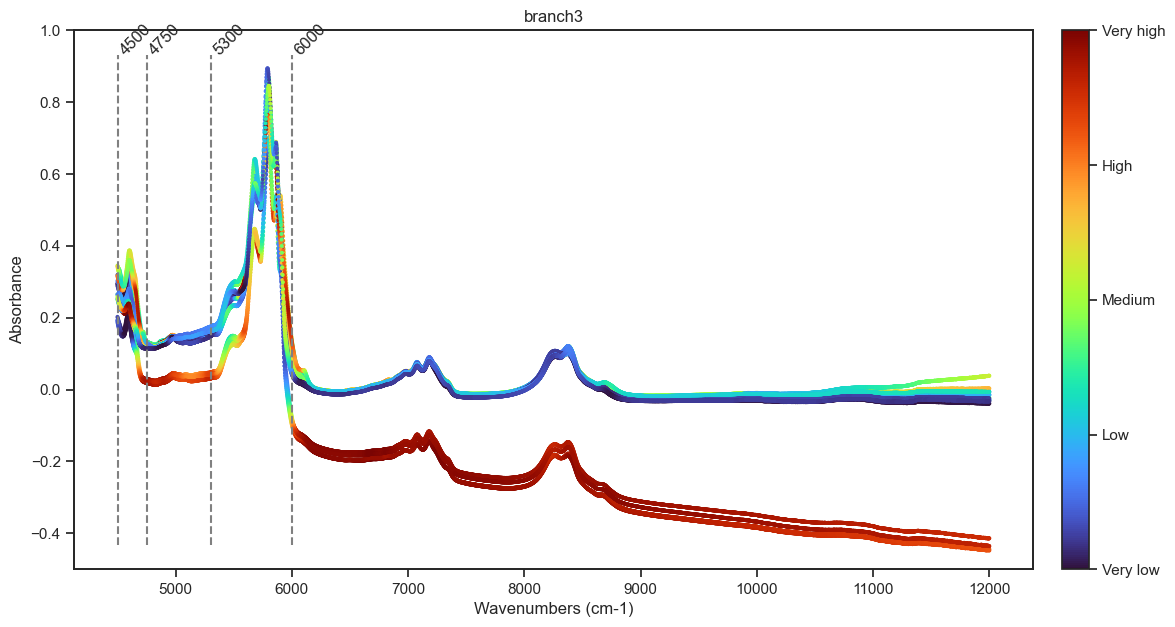

In [21]:
fig, ax1 = plt.subplots(1,1, figsize=(15,7))
plot_activation(interpolated_spectra[index_list], X_train[index_list], ax1, 'branch3')

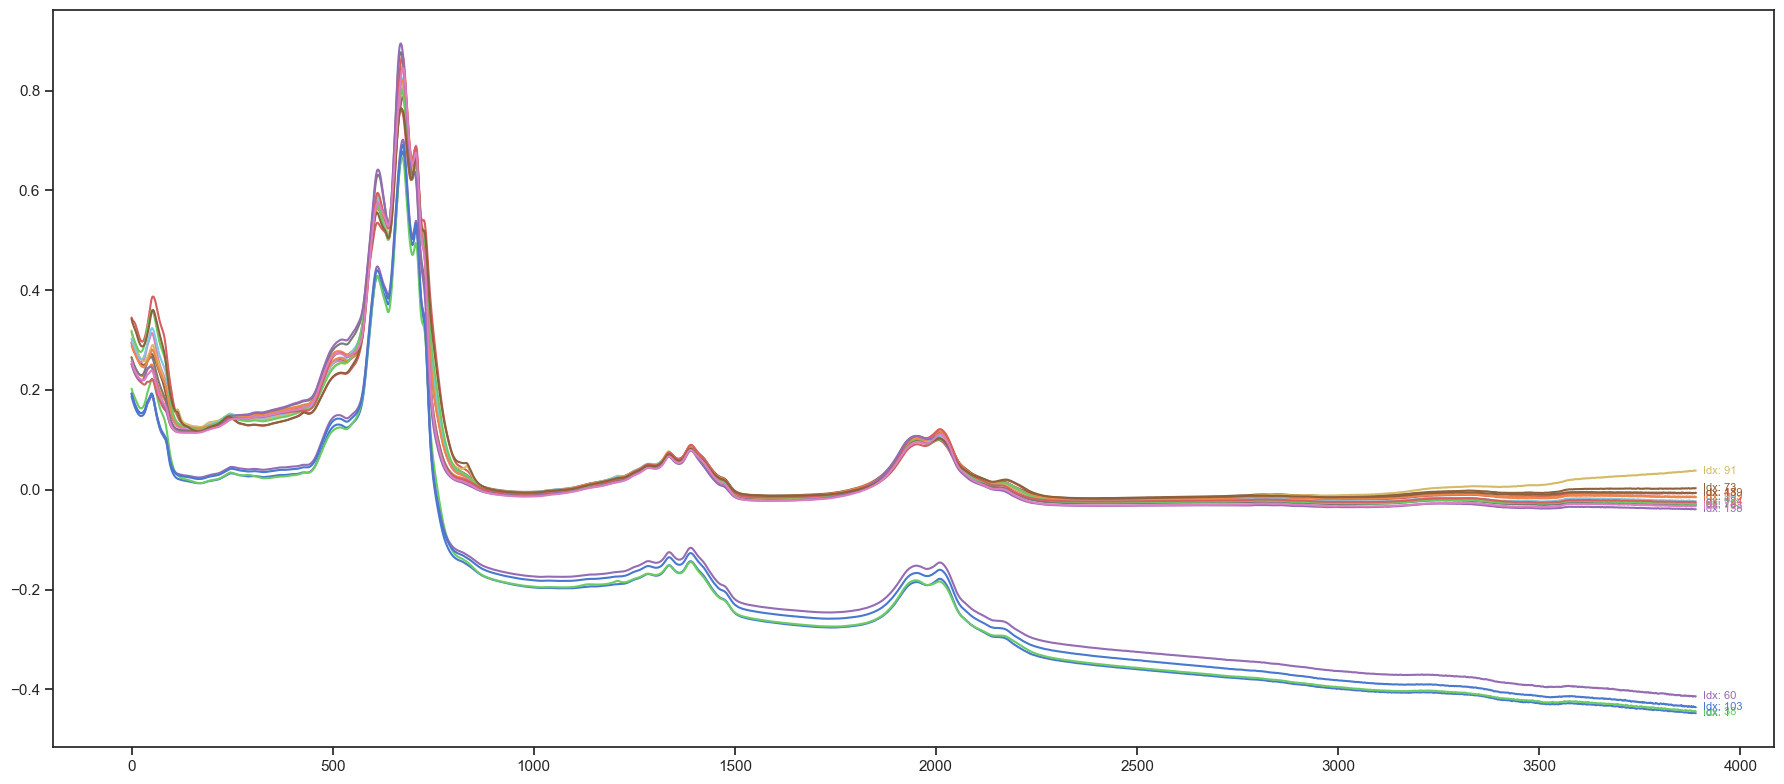

idx_with_baseline: [1, 38, 60, 103]


In [22]:
idx_with_baseline = []
_, ax = plt.subplots(1, figsize=(18,8))

for i in range(len(X_train[index_list])):
    line = plt.plot(X_train[index_list[i]].T, label=index_list[i])
    
    # Get the last x and y coordinates of the line
    x_end = len(X_train[index_list[i]].T) - 1
    y_end = X_train[index_list[i]].T[-1]
    if y_end < -.2: idx_with_baseline.append(index_list[i])
    
    # Add annotation at the end of each line
    ax.annotate(f'Idx: {index_list[i]}', 
                xy=(x_end, y_end),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left',
                va='center',
                fontsize=8,
                color=line[0].get_color())  # Match annotation color to line color

# Adjust layout to prevent clipping of annotations
plt.tight_layout()
# ax.legend()
plt.show()

print(f'idx_with_baseline: {idx_with_baseline}')

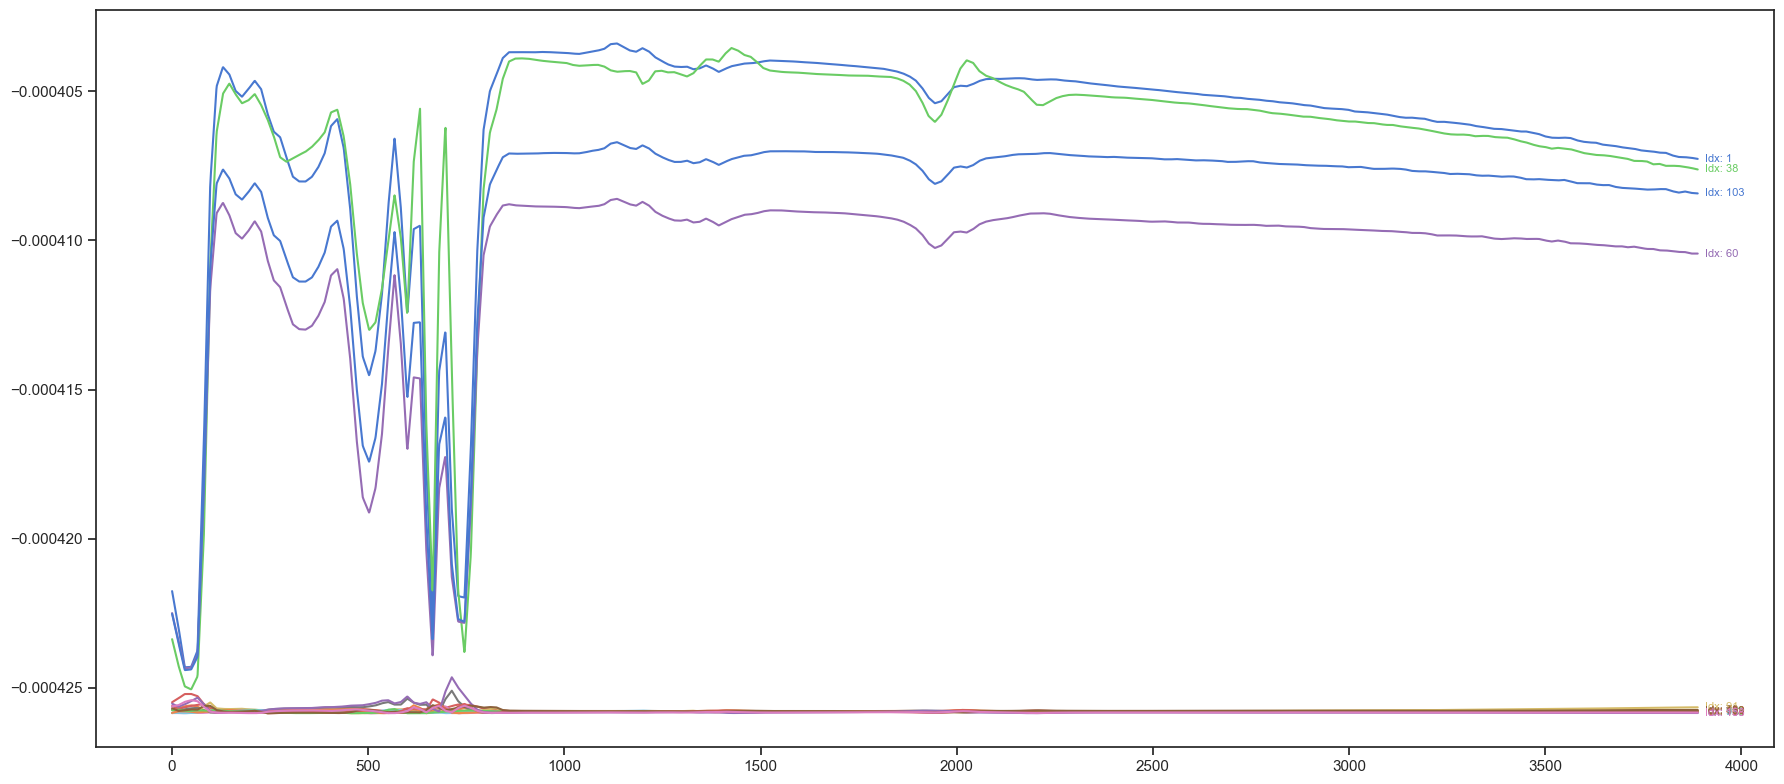

[]


In [23]:
small_activation = []

_, ax = plt.subplots(1, figsize=(18,8))
for i in range(len(interpolated_spectra[index_list])):
    line = plt.plot(interpolated_spectra[index_list[i]].T, label=index_list[i])

    x_end = len(interpolated_spectra[index_list[i]].T) - 1
    y_end = interpolated_spectra[index_list[i]].T[-1]
    if y_end > -.000378: small_activation.append(index_list[i])

    # Add annotation at the end of each line
    ax.annotate(f'Idx: {index_list[i]}', 
                xy=(x_end, y_end),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left',
                va='center',
                fontsize=8,
                color=line[0].get_color())  # Match annotation color to line color

# Adjust layout to prevent clipping of annotations
plt.tight_layout()
plt.show()
# ax.legend()
print(small_activation)

### Stem1

In [24]:
layer_idx = key_to_idx['stem1']['idx']
gap = GlobalAveragePooling1D(data_format='channels_first')(selected_activations[layer_idx-1])
interpolated_spectra = calculate_gradcam()

100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 1060.01it/s]


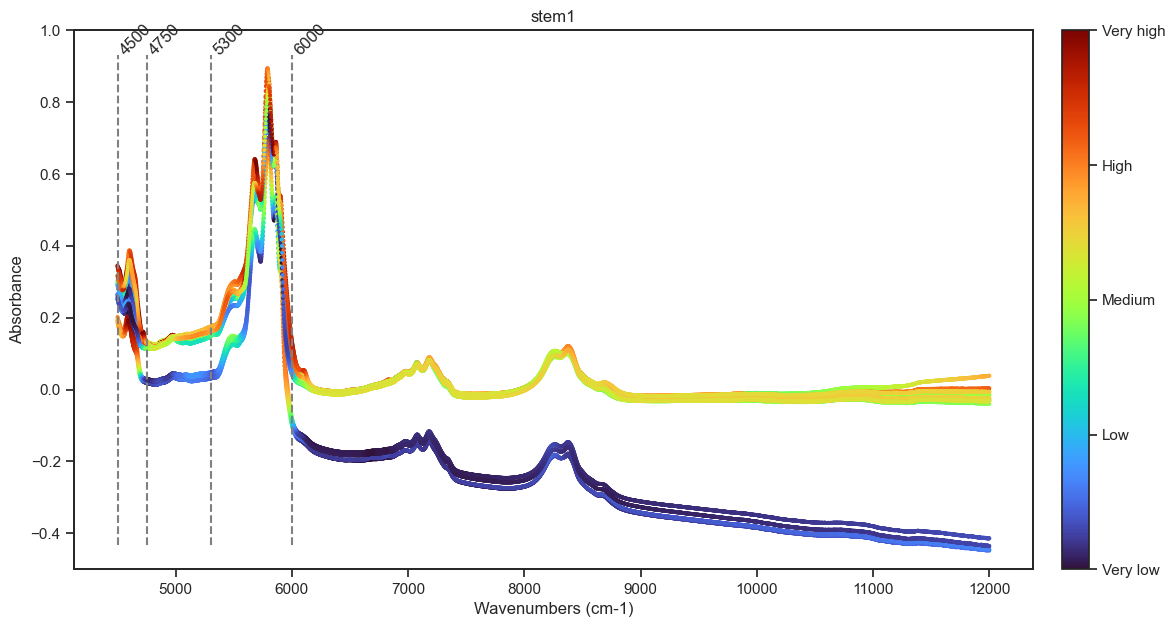

In [25]:
fig, ax1 = plt.subplots(1,1, figsize=(15,7))
plot_activation(interpolated_spectra[index_list], X_train[index_list], ax1, 'stem1')

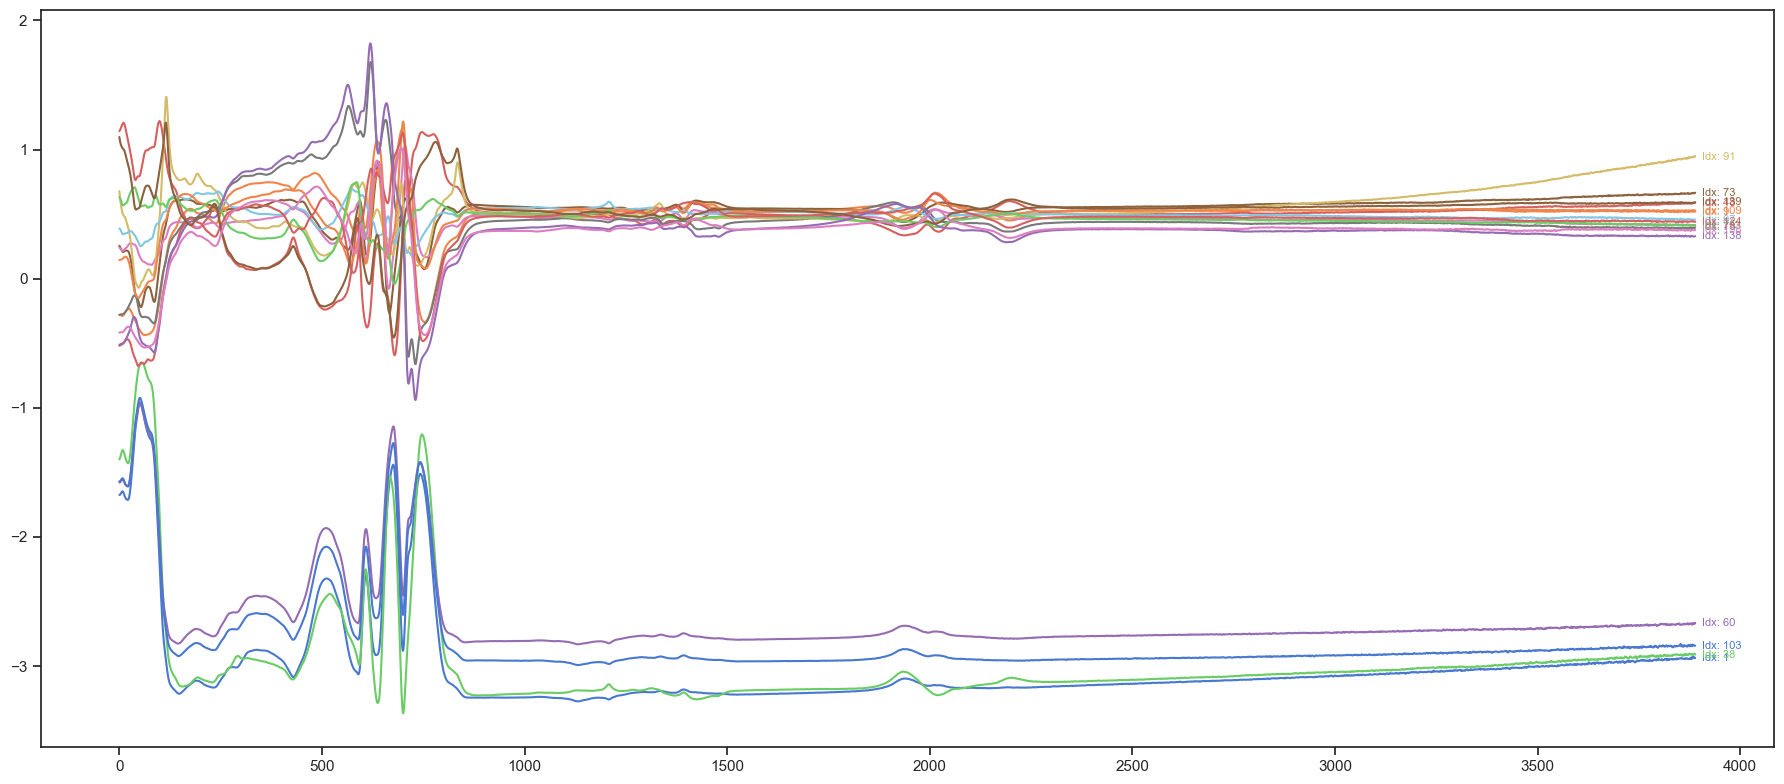

[1, 38, 60, 103]


In [26]:
small_activation = []

_, ax = plt.subplots(1, figsize=(18,8))
for i in range(len(interpolated_spectra[index_list])):
    line = plt.plot(interpolated_spectra[index_list[i]].T, label=index_list[i])

    x_end = len(interpolated_spectra[index_list[i]].T) - 1
    y_end = interpolated_spectra[index_list[i]].T[-1]
    if y_end < -1.: small_activation.append(index_list[i])

    # Add annotation at the end of each line
    ax.annotate(f'Idx: {index_list[i]}', 
                xy=(x_end, y_end),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left',
                va='center',
                fontsize=8,
                color=line[0].get_color())  # Match annotation color to line color

# Adjust layout to prevent clipping of annotations
plt.tight_layout()
plt.show()
print(small_activation)

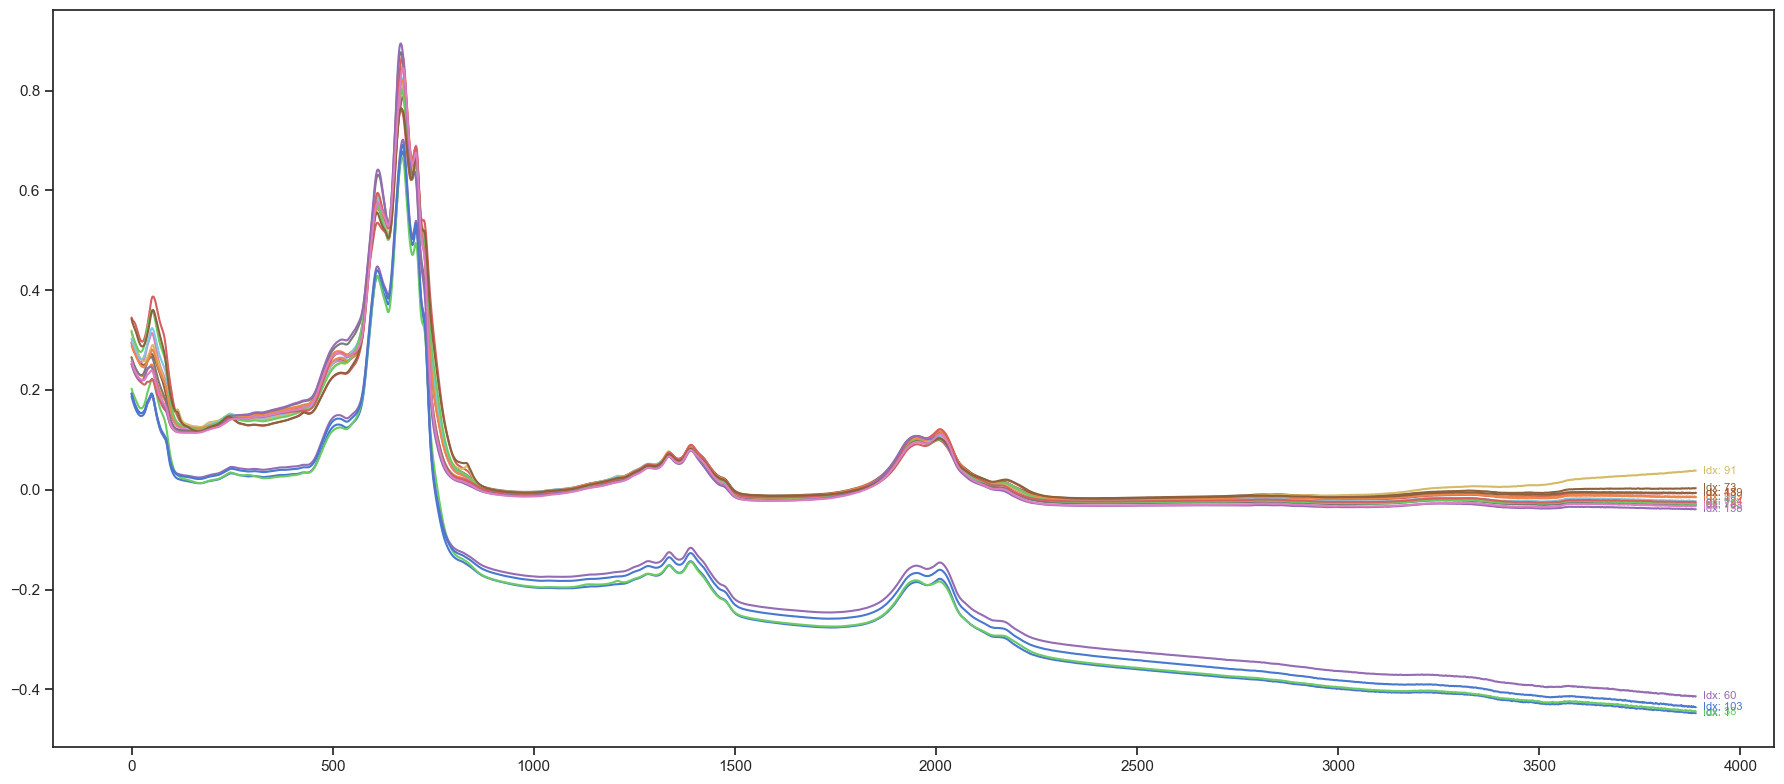

idx_with_baseline: [1, 38, 60, 103]


In [27]:
idx_with_baseline = []
_, ax = plt.subplots(1, figsize=(18,8))

for i in range(len(X_train[index_list])):
    line = plt.plot(X_train[index_list[i]].T, label=index_list[i])
    
    # Get the last x and y coordinates of the line
    x_end = len(X_train[index_list[i]].T) - 1
    y_end = X_train[index_list[i]].T[-1]
    if y_end < -.2: idx_with_baseline.append(index_list[i])
    
    # Add annotation at the end of each line
    ax.annotate(f'Idx: {index_list[i]}', 
                xy=(x_end, y_end),
                xytext=(5, 0),
                textcoords='offset points',
                ha='left',
                va='center',
                fontsize=8,
                color=line[0].get_color())  # Match annotation color to line color

# Adjust layout to prevent clipping of annotations
plt.tight_layout()
plt.show()

print(f'idx_with_baseline: {idx_with_baseline}')